In [1]:
import re
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)

In [4]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
df.shape

(150, 4)

In [6]:
df.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
dtype: object

In [7]:
df.columns


Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [8]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [9]:
def standarise(column,pct,pct_lower):
    sc = StandardScaler() 
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

In [10]:
def fit_distribution(column,pct,pct_lower):
    # Set up list of candidate distributions to use
    y_std,size,y_org = standarise(column,pct,pct_lower)
    dist_names = ['weibull_min','norm','weibull_max','beta',
                 'invgauss','uniform','gamma','expon', 'lognorm','pearson3','triang']

    chi_square_statistics = []
    # 11 bins
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        print("{}\n{}\n".format(dist, param))
      

        # Get expected counts in percentile bins
        # cdf of fitted sistrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency),0)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)


    print ('\nDistributions listed by Betterment of fit:')
    print ('............................................')
    print (results)

In [11]:
fit_distribution('sepal length (cm)',0.99,0.01)

(2.160664918132396, -2.04409048976716, 2.308262471584811)

(1.3050784942532453e-15, 1.0)

(0.7443825944660937, 2.3663868590153285, 1.4856849748952916)

(1.6216397476348305, 2.3509227165578976, -1.8760911746963536, 4.592015432730941)

(0.03683344038944247, -5.286218388952625, 143.52812431300032)

(-1.8033707338227933, 4.169757592838121)

(9.296206287762008, -3.1170587348330017, 0.335304402994417)

(-1.8033707338227933, 1.8033707338227947)

(0.17447832218995593, -5.7532573347863725, 5.666767202750594)

(0.655991868232645, 1.6121065043528303e-15, 1.0223328346371652)

(0.1923378543852389, -1.9425295866270345, 4.665210774687292)


Distributions listed by Betterment of fit:
............................................
   Distribution  chi_square
0   weibull_min         3.0
3          beta         3.0
4      invgauss         4.0
6         gamma         4.0
8       lognorm         4.0
9      pearson3         4.0
1          norm         8.0
10       triang        10.0
5       uniform        18.

In [12]:
y_std,len_y,y = standarise('sepal length (cm)',0.99,0.01)

Text(0, 0.5, 'Frequency')

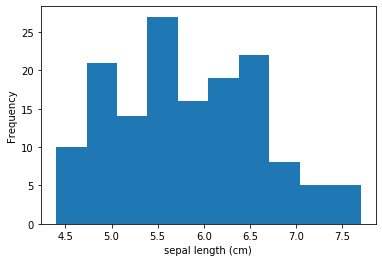

In [13]:
plt.hist(y)
plt.xlabel('sepal length (cm)')
plt.ylabel('Frequency')

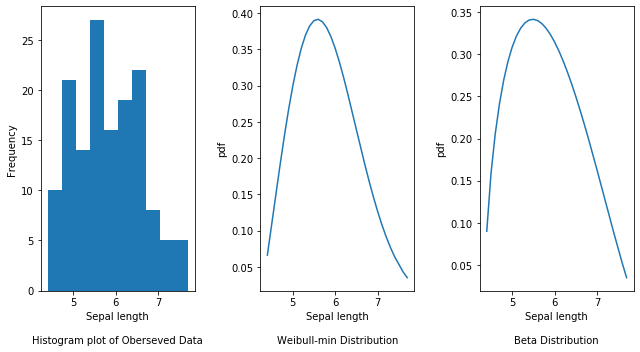

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y)
axes[0].set_xlabel('Sepal length\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')
axes[1].plot(y,weibull_min.pdf(y_std,2.16, -2.04, 2.31))
axes[1].set_xlabel('Sepal length\n\nWeibull-min Distribution')
axes[1].set_ylabel('pdf')
axes[2].plot(y,beta.pdf(y_std,1.62, 2.35, -1.88, 4.60))
axes[2].set_xlabel('Sepal length\n\nBeta Distribution')
axes[2].set_ylabel('pdf')
fig.tight_layout()

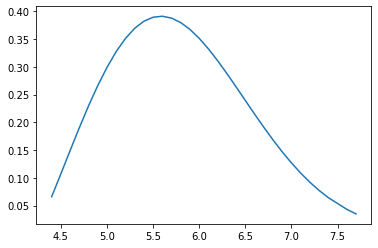

In [15]:
f = plt.figure()
plt.plot(y,weibull_min.pdf(y_std,2.16, -2.04, 2.31))
f.show()

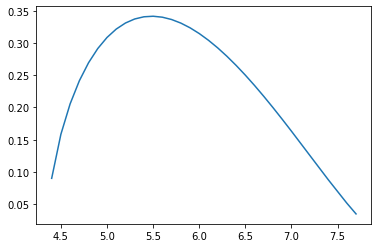

In [16]:
f = plt.figure()
plt.plot(y,beta.pdf(y_std,1.62, 2.35, -1.88, 4.60))
f.show()